# Introduction to Reservoir Computing with ReservoirPy


**by Inria - Mnemosyne, Bordeaux, France.**

## Summary

- <a href="#concepts">Concepts and key features</a>
- <a href="#chapitre1">Chapter 1 : A simple task</a>
- <a href="#chapitre2">Chapter 2 : Generative models</a>
- <a href="#chapitre3">Chapter 3 : Online learning</a>
- <a href="#bonus">Go further : Understand reservoir hyperparameters</a>

## Concepts and key features <a id="concepts"></a>

ReservoirPy project is about:
- Numpy, Scipy, and only Numpy and Scipy
- Efficient execution (distributed computations, optimized learning rules)
- *Online* and *offline* learning rules
- Convenient tools and tutorials for hyperparameters optimization

- Docs: https://reservoirpy.readthedocs.io/en/latest/
- GitHub: https://github.com/reservoirpy/reservoirpy

## Generic information

- All vectors and data arrays are NumPy arrays
- Time is always represented as the first axis of arrays.

In [7]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy
from reservoirpy import mat_gen

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

In [8]:
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

## Chapter 1 : Reservoir Computing for chaotic timeseries forecasting <span id="chapitre1"/>

**Mackey-Glass timeseries**

Mackey-Glass equation are a set of delayed differential equations
describing the temporal behaviour of different physiological signal,
for example, the relative quantity of mature blood cells over time.

The equations are defined as:

$$
\frac{dP(t)}{dt} = \frac{a P(t - \tau)}{1 + P(t - \tau)^n} - bP(t)
$$

where $a = 0.2$, $b = 0.1$, $n = 10$, and the time delay $\tau = 17$.
$\tau$ controls the chaotic behaviour of the equations (the higher it is,
the more chaotic the timeserie becomes.
$\tau=17$ already gives good chaotic results.)

In [9]:
from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

timesteps = 2510
tau = 17
X = mackey_glass(timesteps, tau=tau)

# rescale between -1 and 1
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

In [10]:
def plot_mackey_glass(X, sample, tau):

    fig = plt.figure(figsize=(13, 5))
    N = sample

    ax = plt.subplot((121))
    t = np.linspace(0, N, N)
    for i in range(N-1):
        ax.plot(t[i:i+2], X[i:i+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Timeseries - {N} timesteps")
    plt.xlabel("$t$")
    plt.ylabel("$P(t)$")

    ax2 = plt.subplot((122))
    ax2.margins(0.05)
    for i in range(N-1):
        ax2.plot(X[i:i+2], X[i+tau:i+tau+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
    plt.xlabel("$P(t-\\tau)$")
    plt.ylabel("$P(t)$")

    plt.tight_layout()
    plt.show()

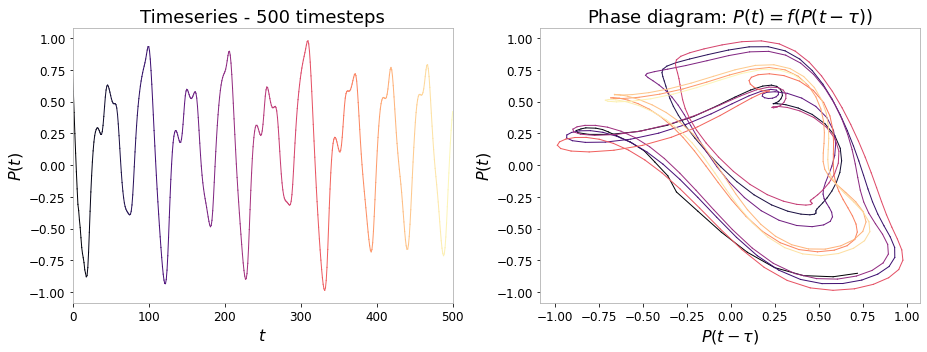

In [11]:
plot_mackey_glass(X, 500, tau)

- Not completely unpredictable... (not random)
- ...but not easily predictable (not periodic)
- Similar to ECG rythms, stocks, weather...

### 1.1. Task 1: 10 timesteps ahead forecast

Predict $P(t + 10)$ given $P(t)$.

#### Data preprocessing

In [12]:
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 500
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 500), X_train[-sample:], label="Données d'entraînement")
    plt.plot(np.arange(0, 500), y_train[-sample:], label="Objectif d'entraînement")
    plt.plot(np.arange(500, 500+test_len), X_test, label="Données de test")
    plt.plot(np.arange(500, 500+test_len), y_test, label="Objectif de test")
    plt.legend()
    plt.show()

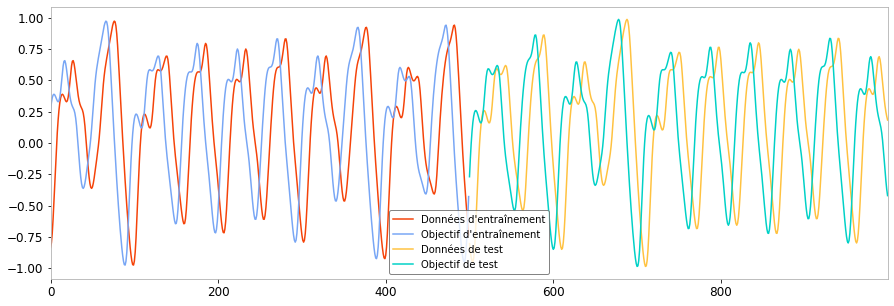

In [13]:
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=10)
X_train1, y_train1 = x[:2000], y[:2000]
X_test1, y_test1 = x[2000:], y[2000:]

plot_train_test(X_train1, y_train1, X_test1, y_test1)

### Build your first Echo State Network

In [14]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

In [15]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
    }
</style>
<div class="img-center">
    <img src="./static/task1.png" width="600">
</div>

In [16]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

<div class="img-center">
    <img src="./static/matrices.png" width="900">
</div>

In [17]:
y = esn(X[0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [18]:
np.all(readout.Wout == 0.0)

True

#### Entraînement de l'ESN

L'apprentissage est *offline* ("hors-ligne") : il n'a lieu qu'une seule fois, sur l'ensemble des données d'entraînement.

In [19]:
esn = esn.fit(X_train1, y_train1)

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running SubModel-8751e93c-b9c9-486b-a24f-731246e0f0fc:   0%|          | 0/1 [00:00<?, ?it/s]
Running SubModel-8751e93c-b9c9-486b-a24f-731246e0f0fc: 822it [00:00, 8213.21it/s]           
Running SubModel-8751e93c-b9c9-486b-a24f-731246e0f0fc: 2000it [00:00, 8437.81it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Fitting node Ridge-0...


In [20]:
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias, Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. de $W_{out}$")
    ax.set_xlabel("Neurones du reservoir")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

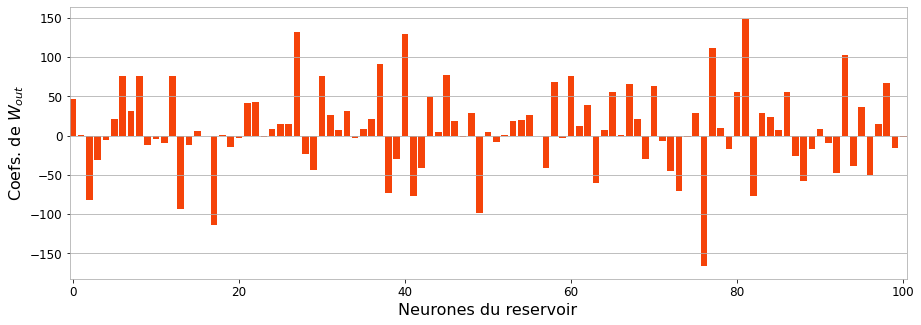

In [21]:
plot_readout(readout)

#### Test de l'ESN

In [22]:
y_pred1 = esn.run(X_test1)

Running Model-0: 100%|██████████| 500/500 [00:00<00:00, 7362.20it/s]


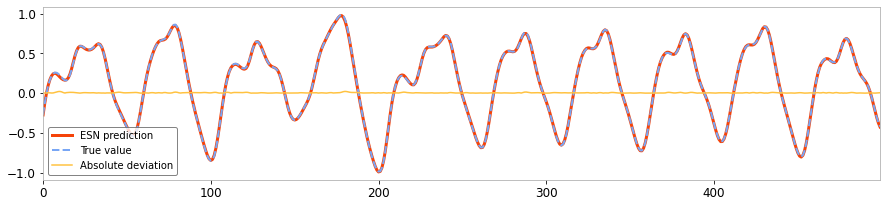

In [23]:
plot_results(y_pred1, y_test1)

Coefficient de détermination $R^2$ et erreur quadratique normalisée :

In [24]:
rsquare(y_test1, y_pred1), nrmse(y_test1, y_pred1)

(0.9998810506313958, 0.0026034595249913566)

### 1.2 Compliquons la tâche

Passons d'un horizon de prédiction de 10 pas de temps à un horizon de 100 pas de temps

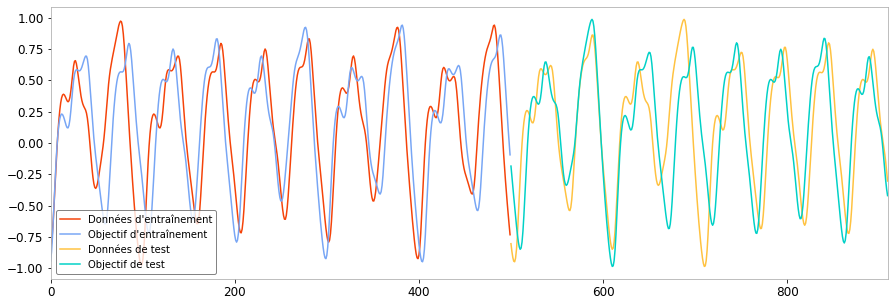

In [25]:
x, y = to_forecasting(X, forecast=100)
X_train2, y_train2 = x[:2000], y[:2000]
X_test2, y_test2 = x[2000:], y[2000:]

plot_train_test(X_train2, y_train2, X_test2, y_test2)

In [26]:
y_pred2 = esn.fit(X_train2, y_train2).run(X_test2)

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running SubModel-376c26d6-e104-4461-b6ce-9f06a6932327:   0%|          | 0/1 [00:00<?, ?it/s]
Running SubModel-376c26d6-e104-4461-b6ce-9f06a6932327: 809it [00:00, 8086.54it/s]           
Running SubModel-376c26d6-e104-4461-b6ce-9f06a6932327: 2000it [00:00, 8103.55it/s]
Running Model-0: 100%|██████████| 410/410 [00:00<00:00, 5925.08it/s]

Fitting node Ridge-0...


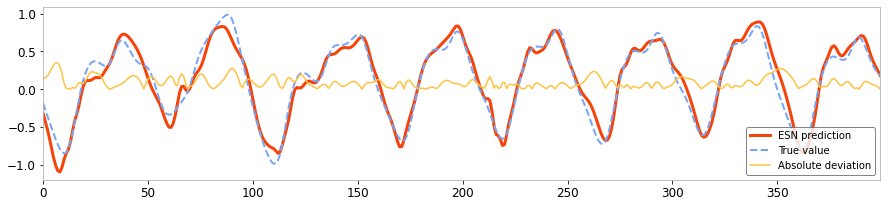

In [27]:
plot_results(y_pred2, y_test2, sample=400)

Determination coefficient $R^2$ and NRMSE:

In [28]:
rsquare(y_test2, y_pred2), nrmse(y_test2, y_pred2)

(0.94803604102033, 0.05593776748240906)

## Chapitre 2 : Déployer les capacités génératives des ESNs <span id="chapitre2"/>

- Entraînement de l'ESN sur une tâche de prédiction de 1 pas de temps.
- Test de l'ESN **sur ses propres prédictions** (mode génératif).

<div>
    <img src="./static/generative.png" width="900">
</div>

In [29]:
units = 500
leak_rate = 0.3         # - leaking rate
spectral_radius = 0.99  # - rayon spectral
input_scaling = 1.0     # - facteur de mise à l'échelle des entrées (input scaling)
connectivity = 0.1      # - densité des connexions du reservoir vers lui même
input_connectivity = 0.2  # et des entrées vers le reservoir
regularization = 1e-4   # - coefficient de régularisation (L2)
seed = 1234             # reproductibilité

In [30]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Série générée")
    else:
        plt.plot(X_gen, label="Série générée")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Série réelle")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Données d'échauffement")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Erreur absolue")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Echauffement")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

#### Entraînement à la prévision sur un horizon court

In [31]:
esn = reset_esn()

x, y = to_forecasting(X, forecast=1)
X_train3, y_train3 = x[:2000], y[:2000]
X_test3, y_test3 = x[2000:], y[2000:]

esn = esn.fit(X_train3, y_train3)

Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]
Running SubModel-268a8912-3af0-40d4-8c33-40a3e91d8477:   0%|          | 0/1 [00:00<?, ?it/s]
Running SubModel-268a8912-3af0-40d4-8c33-40a3e91d8477: 460it [00:00, 4596.92it/s]           
Running SubModel-268a8912-3af0-40d4-8c33-40a3e91d8477: 1071it [00:00, 4964.78it/s]
Running SubModel-268a8912-3af0-40d4-8c33-40a3e91d8477: 2000it [00:00, 5884.19it/s]
Running Model-1: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

Fitting node Ridge-1...


#### Génération

- 100 pas de temps de la série de test utilisés comme "échauffement";
- 300 pas de temps générés "à partir de rien";

In [32]:
seed_timesteps = 100

warming_inputs = X_test3[:seed_timesteps]

warming_out = esn.run(warming_inputs, reset=True)  # échauffement

Running Model-1: 100%|██████████| 100/100 [00:00<00:00, 4127.16it/s]


In [33]:
nb_generations = 400

X_gen = np.zeros((nb_generations, 1))
y = warming_out[-1]
for t in range(nb_generations):  # génération
    y = esn(y)
    X_gen[t, :] = y

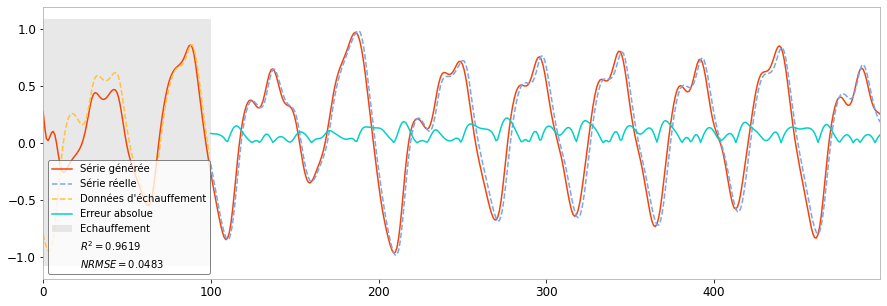

In [34]:
X_t = X_test3[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen, X_t, nb_generations, warming_out=warming_out,
                warming_inputs=warming_inputs, seed_timesteps=seed_timesteps)

## Chapitre 3 : Apprentissage hors-ligne <span id="chapitre3"/>

Apprentissage se déroulant de manière *incrémentale*.

Utilisation de l'algorithme **FORCE** *(Sussillo and Abott, 2009)*

<div>
    <img src="./static/online.png" width="700">
</div>

In [35]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
seed = 1234

In [36]:
from reservoirpy.nodes import FORCE

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = FORCE(1)


esn_online = reservoir >> readout

#### Entraînement pas à pas

In [37]:
outputs_pre = np.zeros(X_train1.shape)
for t, (x, y) in enumerate(zip(X_train1, y_train1)): # pour chaque pas de temps de la série :
    outputs_pre[t, :] = esn_online.train(x, y)

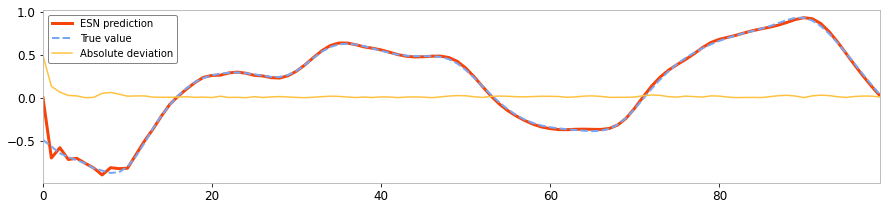

In [38]:
plot_results(outputs_pre, y_train1, sample=100)

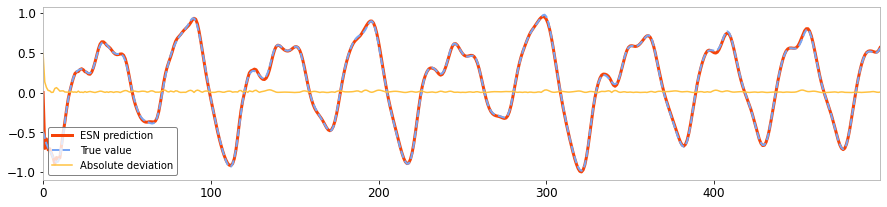

In [39]:
plot_results(outputs_pre, y_train1, sample=500)

#### Entraînement sur une séquence complète

In [40]:
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = FORCE(1)


esn_online = reservoir >> readout

In [41]:
esn_online.train(X_train1, y_train1)

pred_online = esn_online.run(X_test1)  # Wout est maintenant figée

Running Model-3: 100%|██████████| 500/500 [00:00<00:00, 5317.43it/s]


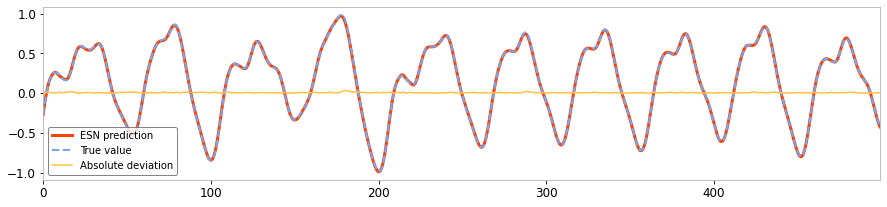

In [42]:
plot_results(pred_online, y_test1, sample=500)

Determination coefficient $R^2$ and NRMSE:

In [43]:
rsquare(y_test1, pred_online), nrmse(y_test1, pred_online)

(0.9998104511137069, 0.0032864753423817064)

## Chapitre 4 : Application réelle : chute de robot <span id="chapitre4"/>

<div>
    <img src="./static/sigmaban.png" width="500">
</div>

#### Chargement et préparation des données

In [44]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from joblib import delayed, Parallel
from tqdm import tqdm

In [45]:
features = ['com_x', 'com_y', 'com_z', 'trunk_pitch', 'trunk_roll', 'left_x', 'left_y',
            'right_x', 'right_y', 'left_ankle_pitch', 'left_ankle_roll', 'left_hip_pitch',
            'left_hip_roll', 'left_hip_yaw', 'left_knee', 'right_ankle_pitch',
            'right_ankle_roll', 'right_hip_pitch', 'right_hip_roll',
            'right_hip_yaw', 'right_knee']

prediction = ['fallen']
force = ['force_orientation', 'force_magnitude']

In [46]:
files = glob.glob("r4-data/experiments/*")
dfs = []

with Parallel(n_jobs=-1) as parallel:
    dfs = parallel(delayed(pd.read_csv)(f, compression="gzip", header=0, sep=",") for f in tqdm(files))

0it [00:00, ?it/s]


In [47]:
X = []
Y = []
F = []
for i, df in enumerate(dfs):
    X.append(df[features].values)
    Y.append(df[prediction].values)
    F.append(df["force_magnitude"].values)

In [48]:
Y_train = []
for y in Y:
    y_shift = np.roll(y, -500)
    y_shift[-500:] = y[-500:]
    Y_train.append(y_shift)

In [49]:
def plot_robot(Y, Y_train, F):
    plt.figure(figsize=(10, 7))
    plt.plot(Y_train[1], label="Objectif")
    plt.plot(Y[1], label="Indicateur de chute")
    plt.plot(F[1], label="Force appliquée")
    plt.legend()
    plt.show()

In [50]:
plot_robot(Y, Y_train, F)

IndexError: list index out of range

<Figure size 720x504 with 0 Axes>

#### Entraînement de l'ESN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_train, test_size=0.2, random_state=42)

In [ ]:
from reservoirpy.nodes import ESN

reservoir = Reservoir(300, lr=0.5, sr=0.99, input_bias=False)
readout   = Ridge(1, ridge=1e-3)
esn = ESN(reservoir=reservoir, readout=readout, workers=-1)  # version distribuée

In [ ]:
esn = esn.fit(X_train, y_train)

In [ ]:
res = esn.run(X_test)

In [ ]:
from reservoirpy.observables import rmse
scores = []
for y_t, y_p in zip(y_test, res):
    score = rmse(y_t, y_p)
    scores.append(score)


filt_scores = []
for y_t, y_p in zip(y_test, res):
    y_f = y_p.copy()
    y_f[y_f > 0.5] = 1.0
    y_f[y_f <= 0.5] = 0.0
    score = rmse(y_t, y_f)
    filt_scores.append(score)

In [ ]:
def plot_robot_results(y_test, y_pred):
    for y_t, y_p in zip(y_test, y_pred):
        if y_t.max() > 0.5:
            y_shift = np.roll(y, 500)
            y_shift[:500] = 0.0

            plt.figure(figsize=(7, 5))
            plt.plot(y_t, label="Objectif")
            plt.plot(y_shift, label="Chute")
            plt.plot(y_p, label="Prediction")
            plt.legend()
            plt.show()
            break

In [ ]:
plot_robot_results(y_test, res)

In [ ]:
print("RMSE moyenne :", f"{np.mean(scores):.4f}", "±", f"{np.std(scores):.5f}")
print("RMSE moyenne (avec seuil) :", f"{np.mean(filt_scores):.4f}", "±", f"{np.std(filt_scores):.5f}")

## Chapitre 5 : Application réelle : le chant des canaris domestiques <span id="chapitre5"/>

Les données peuvent être téléchargées sur Zenodo :
https://zenodo.org/record/4736597

In [ ]:
im = plt.imread("./static/canary.png")
plt.figure(figsize=(5, 5)); plt.imshow(im); plt.axis('off'); plt.show()

In [ ]:
from IPython.display import Audio

audio = Audio(filename="./static/song.wav")

In [ ]:
display(audio)

Plusieurs motifs temporels répétitifs differents à décoder : les *phrases*.


- Un label par type de phrase à classifier dans le temps.
- Un label *SIL* annotant le silence, à détecter également pour permettre la segmentation du chant.

In [ ]:
im = plt.imread("./static/canary_outputs.png")
plt.figure(figsize=(15, 15)); plt.imshow(im); plt.axis('off'); plt.show()

#### Chargement et préparation des données

In [ ]:
import os
import glob
import math
import pandas as pd
import librosa as lbr

from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import OneHotEncoder

win_length = 1024
n_fft = 2048
hop_length = 512
fmin = 500
fmax = 8000
lifter = 40
n_mfcc = 13


def load_data(directory, max_songs=100):
    audios = sorted(glob.glob(directory + "/**/*.wav", recursive=True))
    annotations = sorted(glob.glob(directory + "/**/*.csv", recursive=True))


    X = []
    Y = []
    vocab = set()

    max_songs = min(len(audios), max_songs)

    for audio, annotation, _ in tqdm(zip(audios, annotations, range(max_songs)), total=max_songs):
        df = pd.read_csv(annotation)
        wav, rate = lbr.load(audio, sr=None)
        x = lbr.feature.mfcc(wav, sr=rate,
                              win_length=win_length, hop_length=hop_length,
                              n_fft=n_fft, fmin=fmin, fmax=fmax, lifter=lifter,
                              n_mfcc=n_mfcc)
        delta = lbr.feature.delta(x, mode="wrap")
        delta2 = lbr.feature.delta(x, order=2, mode="wrap")

        X.append(np.vstack([x, delta, delta2]).T)

        y = [["SIL"]] * x.shape[1]

        for annot in df.itertuples():
            start = max(0, round(annot.start * rate / hop_length))
            end = min(x.shape[1], round(annot.end * rate / hop_length))
            y[start:end] = [[annot.syll]] * (end - start)
            vocab.add(annot.syll)

        Y.append(y)

    return X, Y, list(vocab)

X, Y, vocab = load_data("./canary-data")

#### One-hot encoding des labels de phrase

In [ ]:
one_hot = OneHotEncoder(categories=[vocab], sparse=False)

Y = [one_hot.fit_transform(np.array(y)) for y in Y]

Dans un premier (court) temps, on se limitera à traiter 100 chants. L'entraînement sera effectué sur les 90 premiers, et le test sur les 10 derniers.

Au total, il y a 459 chants, il est donc possible de varier les constructions de jeu de données, voire de tester la robustesse des résultats par validation croisée.

In [ ]:
X_train, y_train = X[:-10], Y[:-10]
X_test, y_test = X[-10:], Y[-10:]

#### Entraînement de l'ESN

In [ ]:
from reservoirpy.nodes import ESN

units = 1000
leak_rate = 0.05
spectral_radius = 0.5
inputs_scaling = 0.001
connectivity = 0.1
input_connectivity = 0.1
regularization = 1e-5
seed = 1234

Win = mat_gen.generate_input_weights(units, n_mfcc*3, input_scaling=inputs_scaling,
                                     proba=input_connectivity, input_bias=True,
                                     seed=seed)

reservoir = Reservoir(units, sr=spectral_radius, Win=Win,
                      lr=leak_rate, rc_connectivity=connectivity,
                      seed=seed)

readout = Ridge(len(vocab), ridge=regularization)


esn = ESN(reservoir=reservoir, readout=readout, workers=-1, backend="loky")

In [ ]:
esn = esn.fit(X_train, y_train)

In [ ]:
outputs = esn.run(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

scores = []
for y_t, y_p in zip(y_test, outputs):
    targets = np.vstack(one_hot.inverse_transform(y_t)).flatten()

    top_1 = np.argmax(y_p, axis=1)
    top_1 = np.array([vocab[t] for t in top_1])

    accuracy = accuracy_score(targets, top_1)

    scores.append(accuracy)

In [ ]:
scores  # pour chaque chant testé

In [ ]:
print("Précision moyenne :", f"{np.mean(scores):.4f}", "±", f"{np.std(scores):.5f}")

#### Pour aller plus loin

- Essayer de varier le nombre de chants entraînés : combien faut-il de chants au minimum pour reproduire les résultats obtenus sur 100 chants ?
- Trouver le meilleur jeu d'hyperparamètres : outils basés sur la bibliothèque *hyperopt* (https://github.com/hyperopt/hyperopt).
- Essayer d'appliquer un *input scaling* différent pour chaque groupe de variables d'intérêt.

## Merci de votre attention.


**Nathan Trouvain <br>
Inria - Mnemosyne**

<br>
<br>
<br>
R4 - 9 novembre 2021

## Aller plus loin : Comprendre les hyperparamètres et leurs effets <span id="bonus"/>

In [ ]:
units = 100             # - nombre de neurones dans le reservoir
leak_rate = 0.3         # - leaking rate
spectral_radius = 1.25  # - rayon spectral
input_scaling = 1.0     # - facteur de mise à l'échelle des entrées
connectivity = 0.1      # - densité des connexions du reservoir vers lui même
input_connectivity = 0.2  # et des entrées vers le reservoir
regularization = 1e-8   # - coefficient de régularisation (L2)
seed = 1234             # reproductibilité

### 1. Le rayon spectral

Le rayon spectral est **la valeur propre maximale de la matrice des poids du réservoir ($W$)**.

In [ ]:
states = []
radii = [0.1, 1.25, 10.0]
for sr in radii:
    reservoir = Reservoir(units, sr=sr, input_scaling=0.1, lr=leak_rate, rc_connectivity=connectivity,
                         input_connectivity=input_connectivity)

    s = reservoir.run(X_test1[:500])
    states.append(s)

In [ ]:
units_nb = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(radii)*100+10+i+1)
    plt.plot(s[:, :units_nb], alpha=0.6)
    plt.ylabel(f"$sr={radii[i]}$")
plt.xlabel(f"Activations ({units_nb} neurons)")
plt.show()

- $-$ rayon spectral $\rightarrow$ dynamiques **stables**

- $+$ rayon spectral $\rightarrow$ dynamiques **chaotiques**

Rayon spectral et *Echo State Property* : rayon spectral $\rightarrow$ 1 (assure que les états internes ne sont pas affectés par l'initialisation).

### 2. Le facteur de mise à l'échelle des entrées (*input scaling*)

Il s'agit d'un **coefficient appliqué à $W_{in}$**, venant changer l'échelle des données en entrée.

In [ ]:
states = []
scalings = [0.01, 0.1, 1.]
for iss in scalings:
    reservoir = Reservoir(units, sr=spectral_radius, input_scaling=iss, lr=leak_rate,
                          rc_connectivity=connectivity, input_connectivity=input_connectivity)

    s = reservoir.run(X_test1[:500])
    states.append(s)

In [ ]:
def correlation(states, inputs):
    return np.mean([np.correlate(states[:, i].flatten(), inputs.flatten()) for i in range(states.shape[1])])

In [ ]:
units_nb = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(scalings)*100+10+i+1)
    plt.plot(s[:, :units_nb], alpha=0.6)
    plt.ylabel(f"$iss={scalings[i]}$")
plt.xlabel(f"Activations ({units_nb} neurons)")
plt.show()

Correlation moyenne des activités des neurones du reservoir avec les entrées :

In [ ]:
for i, s in enumerate(states):
    corr = correlation(states[i], X_test1[:500])
    print(f"ISS : {scalings[i]}, correlation moyenne : {corr}")

- $+$ input scaling $\rightarrow$ activités **corrélées aux données**
- $-$ input scaling $\rightarrow$ activités **libres**

L'*input scaling* peut aussi être utilisé pour ajuster l'influence de chaque donnée en entrée.

### 3. Le taux de fuite de la mémoire (*leaking rate*)


$$
x(t+1) =  \underbrace{\color{red}{(1 - \alpha)} x(t)}_{\text{état actuel}} + \underbrace{\color{red}\alpha f(u(t+1), x(t))}_{\text{données suivantes}}
$$

avec $\alpha \in [0, 1]$ et:

$$ f(u, x) = \tanh(W_{in} \cdotp u + W \cdotp x) $$

In [ ]:
states = []
rates = [0.02, 0.2, 0.9]
for lr in rates:
    reservoir = Reservoir(units, sr=spectral_radius, input_scaling=input_scaling, lr=lr,
                          rc_connectivity=connectivity, input_connectivity=input_connectivity)

    s = reservoir.run(X_test1[:500])
    states.append(s)

In [ ]:
units_nb = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(rates)*100+10+i+1)
    plt.plot(s[:, :units_nb] + 2*i)
    plt.ylabel(f"$lr={rates[i]}$")
plt.xlabel(f"States ({units_nb} neurons)")
plt.show()

- $+$ leaking rate $\rightarrow$ **faible inertie**, faible mémorisation des états précédents
- $-$ leaking rate $\rightarrow$ **forte inertie**, grande mémorisation des états précédents

Le *leaking rate* contrôle la "mémoire" de l'ESN. Il peut être vu comme l'inverse de sa constante de temps